# Construct a trajectory one step at a time

We aim to predict the next steps and actions based on time series

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [19]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [21]:
import import_ipynb

from Process_Training_Data import class_to_action
from Process_Training_Data import norm

## Multi-step model using single step-multioutput model

In [22]:
model = tf.keras.models.load_model('./data/S2S_S2A_model.h5')

In [23]:
data_stats = pd.read_csv("./data/data_stats.csv")

In [24]:
import os, sys
sys.path.append('c:\\Users\\pasky\\Documents\\Master_en_Matematicas\\PFM\\Neuronal_Networks\\path_planning')

In [25]:
from simulate_clean import get_next_state
from clean_model import tc
from classes import FlightState

In [26]:
def distance_error(x, z, pitch, u, v):
    distancia = math.sqrt(x**2 + z**2)
    # distancia = math.sqrt(x**2 + z**2 + pitch**2 + u**2 + v**2)
    return distancia

In [27]:
def generate_trajectory(model, start, target, initial_action):
  # Evaluation step (generating trajectory using the learned model)
  # start(9), target(9)

  # Number of points to generate
  num_generate = 6

  # time step used in the action
  time_step = 12/tc
  
  # Get Flight status target
  FS_target = FlightState.order_as_input(target[0:6],target[6], target[7])
  
  # Get Flight status start
  FS_start = FlightState.order_as_input(start[0:6],start[6], start[7])
  FS_current_state = FS_start

  # Compute the initial distance
  distance_long = target - start

  # normalize and add the action to get the Neuronal Network input
  distance = norm(distance_long[0:6], data_stats)
  input_eval = tf.expand_dims([distance], 0)
  

  # Empty vector to store the actions
  trajectory_generated = []

  # Empty vector to store the actions
  actions = []

  # First point is the initial distance
  trajectory_generated.append(distance)

  # initialize cost
  cost = 0

  #initialize distance error
  distancia_error = distance_error(*distance_long[0:5])

  #initialize action vector
  actions.append(initial_action)

  # Here batch size == 1 and sequence size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      action = tf.squeeze(predictions, 0)
      
      actions.append(np.array(action))

      #Expand the action vector with the time step
      action_long = np.append(action, time_step)

      # new_state, boolean = get_next_state(current_state(9), action(2), target_state(6))
      FS_new_state, boolean = get_next_state(FS_current_state, action_long,  FS_target)

      if boolean > 0:

        # We pass the predicted point as the next input to the model
        # along with the previous hidden state
        FS_current_state = FS_new_state
        current_state= FS_current_state.get_info_formatted()
        distance_long = target - current_state

        distance = norm(distance_long[0:6], data_stats)
        input_eval = tf.expand_dims([distance], 0)

        trajectory_generated.append(distance)

        cost = current_state[8]

        #Error distancia = raiz(x, z, pitch, velocidad) de la suma de los cuadrados de las que estan dentro. La velocidad es... velocidad = raiz(u**2 + v**2)
        distancia_error = distance_error(*distance_long[0:5])

      elif boolean == 0:
        print("End")
        end_message = "End"
        break

      else:
        print("Error")
        end_message = "Error"
        break 
          

  return trajectory_generated, cost, distancia_error, actions, end_message

In [28]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [45]:
sample_id = 8
initial_action = np.array(samples['h_actions'][sample_id][0])
start = np.array(samples['initial_state'][sample_id])
target = np.array(samples['final_state'][sample_id])
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(norm(sample[0:6],data_stats))
teorico = np.array(teorico)

In [46]:
trajectory, cost, distancia_error, actions, end_message= generate_trajectory(model, start, target, initial_action)
trajectory = np.array(trajectory)



End


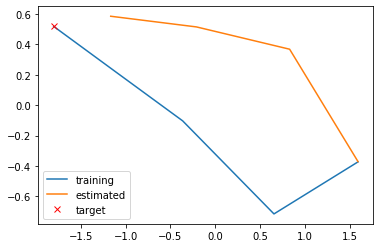

3598.50432216739
419.4809939285981


In [47]:
plt.plot(teorico[:,0], teorico[:,1],  label="training")
plt.plot(trajectory[:,0], trajectory[:,1], label="estimated")
D0 = norm([0,0,0,0,0,0], data_stats)
plt.plot(D0[0], D0[1],"rx", label="target")
plt.legend()
plt.show()
print(cost)
print(distancia_error)

In [32]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(results['h_actions'][sample_id][0])
    start = np.array(results['initial_state'][sample_id])
    target = np.array(results['final_state'][sample_id])
    start_time = time.time()
    trajectory, cost, distancia_error, actions, end_message = generate_trajectory(model, start, target, initial_action)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distancia_error
    results.at[sample_id, 'end_message'] = end_message
    

    

0
Model Error
Error
1
End
2
End
3
End
4
End
5
End
6
End
7
End
8
End
9
Model Error
Error
10
End
11
End
12
Model Error
Error
13
End
14
End
15
End
16
End
17
End
18
Model Error
Error
19
End
20
odeint esta hervi'o
Error
21
End
22
End
23
End
24
End
25
End
26
End
27
odeint esta hervi'o
Error
28
odeint esta hervi'o
Error
29
End
30
End
31
End
32
End
33
End
34
End
35
End
36
End
37
End
38
End
39
End
40
End
41
End
42
End
43
End
44
End
45
odeint esta hervi'o
Error
46
Model Error
Error
47
End
48
End
49
End
50
End
51
Model Error
Error
52
End
53
End
54
End
55
End
56
Model Error
Error
57
Model Error
Error
58
End
59
End
60
End
61
End
62
End
63
End
64
End
65
End
66
End
67
End
68
End
69
End
70
End
71
End
72
End
73
End
74
End
75
End
76
End
77
End
78
odeint esta hervi'o
Error
79
End
80
End
81
odeint esta hervi'o
Error
82
End
83
End
84
Model Error
Error
85
odeint esta hervi'o
Error
86
End
87
odeint esta hervi'o
Error
88
End
89
End
90
odeint esta hervi'o
Error
91
End
92
End
93
End
94
Model Error
Error
95
odei

In [33]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table



,sample,result_end,result_error
h_cost,5215.39,3358.14,1428.11
h_distance,3.95573,516.459,1696.58
h_time,388.612,1.72607,1.52938


In [55]:
np.sum(results["end_message"] == "Error")

20

In [34]:
results.to_csv(r"./data/RNN_samples_metric_S2A.csv")